In [1]:
import os
import time
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt


In [2]:
'''
def city_dis(records):
    num = records.__len__()
    x = np.zeros(num)
    y = np.zeros(num)
    for i in range(1, num + 1):
        x[i - 1] = records[i][0]
        y[i - 1] = records[i][1]
    vertice_cord = np.stack((x, y), axis=1)
    inner = -2 * vertice_cord.dot(vertice_cord.T)
    xx = np.sum(vertice_cord ** 2, axis=1, keepdims=True)
    edge_dist = xx + inner + xx.T
    edge_dist = edge_dist ** 0.5
    np.seterr(invalid='ignore')
    index = list(range(num))
    
    edge_dist[index, index] = 9999999.
    return vertice_cord, edge_dist
'''
def city_dis(records):
    """
        返回各个点的坐标 ndarray
        以及每个点之间的距离矩阵 ndarray
    """
    num = records.__len__()  # 城市数量
    x = np.zeros(num)
    y = np.zeros(num)
    for i in range(1, num + 1):  # 取城市的横纵坐标
        x[i - 1] = records[i][0]
        y[i - 1] = records[i][1]
    vertice_cord = np.stack((x, y), axis=1)  # 再将横纵坐标结对,ndarray
    #(a,b),(c,d)   (a-b)^2 + (c-d)^2
    inner = -2 * vertice_cord.dot(vertice_cord.T)  # -2(ab+cd) 点积,求得点到各个点的坐标对应元素乘积和*-2
    xx = np.sum(vertice_cord ** 2, axis=1, keepdims=True)  # xx:a^2+b^2,... 点坐标两值平方后求和,长num
    edge_dist = xx + inner + xx.T  # xx+xx.T : num*num a^2... 各个点 点坐标两值平方后求和 的 组合,num*num
    edge_dist = edge_dist ** 0.5  #  # a^2 -2ab + b^2 + c^2 - 2cd + d^2
    np.seterr(invalid='ignore')
    index = list(range(num))
    # 为了防止蚂蚁出现自旋，邻接矩阵上的对角线取值尽量大一点。
    edge_dist[index, index] = 9999999.
    return vertice_cord, edge_dist


def a_res(samples, m):
    """
    轮盘赌函数
    samples: [(item, weight), ...]  weight:p(i,j),从i到各个j点的概率
    m: number of selected items
    return: [(item, weight), ...]
    """

    heap = []  # [(new_weight, item), ...]
    for sample in samples:  # 各个点及其概率
        wi = sample[1]
        if wi == 0:  # 如果已经经过过了
            continue
        ui = random.uniform(0, 1)
        ki = ui ** (1 / wi)  # 概率取倒数后作为[0,1]随机数的指数,轮盘? wi越大意味着ki更可能更大

        if len(heap) < m:
            heapq.heappush(heap, (ki, sample))
        elif ki > heap[0][0]:
            heapq.heappush(heap, (ki, sample))

            if len(heap) > m:
                heapq.heappop(heap)  # 堆排序,堆首元素为(ki,(item, weight))的最大值

    return [item[1] for item in heap]  # 返回排序后的m对(item, weight)


def a_res_new(samples):
    """
    轮盘赌函数
    samples: [(item, weight), ...]  weight:p(i,j),从i到各个j点的概率
    m: number of selected items
    return: [(item, weight), ...]
    """
    loc_max = (0., samples[0])
    for sample in samples:  # 各个点及其概率
        wi = sample[1]
        if wi == 0:  # 如果已经经过过了
            continue
        ui = random.uniform(0, 1)
        ki = ui ** (1 / wi)  # 概率取倒数后作为[0,1]随机数的指数,轮盘? wi越大意味着ki更可能更大
        if ki > loc_max[0]:
            loc_max = (ki, sample)

    return loc_max[1]  # 返回排序后的1对(item, weight)


def possibility(eta, gamma, other_city, cur_city):
    """
    返回候选城市集合中，从start到各候选城市的概率，返回所有有路径的
    gamma: 信息素浓度 ndarray
    eta: 启发值/信息素的能见度 ndarray
    """
    alpha = 1  # 信息浓度的权重
    beta = 8  # 启发因子的权重
    start_city = cur_city[-1]

    t_i = gamma[start_city]
    n_i = eta[start_city]  # 取连结start_city和各个城市之间的启发值

    Temp = (t_i ** alpha * n_i ** beta)
    Temp[cur_city] = 0  # 给已经到过的城市置0
    add = Temp.sum()  # 公式分母
    p_ij = Temp / add  # 整体代入公式

    return p_ij  # 返回p(i,j)的值


def rotate(lis, n):
    """
    将列表在n处断开首尾互换
    """
    return lis[n:] + lis[:n]


def get_path_dis(route, Edge):
    """
    获取该路径距离。
    """
    dis = Edge[route[:-1], route[1:]].sum()  # 路线上的点错开1位结对后求路径
    return dis + Edge[route[0], route[-1]]


def ACO(Vertice, Edge, M, num):
    """
    Ant system  超参数
    V : 点集 np.ndarray对象
    E: 邻接矩阵，点之间的连接性 np.ndarray对象
    M: 蚂蚁数量
    num：迭代次数
    """
    # 相关参数
    global_best_path = None  # 当前最优路径
    global_best_dis = 9999999.
    cur_city = None
    other_city = [i for i in range(len(Vertice))]  # 非禁忌表
    lo = 0.2  # 信息素挥发率

    # 信息素启发值
    eta = 1 / Edge  # np.ndarray对象元素整体被1除
    eta[np.isinf(eta)] = 0  # 将元素inf变为0  np.isinf(eta)返回同样shape的ndarray,元素为对应是否为inf的判断

    # 信息素浓度
    E_mean = Edge[Edge > 0].mean()  # E[E > 0]返回E中所有大于0的元素组成的ndarray
    gamma = np.full(Edge.shape, 1 / len(Vertice))  # 用1/len(V)初始化i和j之间的路径信息素浓度, np.full()返回和第一个参数指定shape的ndarray

    V_index = list(range(len(Vertice)))  # 各个点的索引

    for i in range(num):  # 重复迭代num次
        start_time = time.time()
        epoch_gamma = np.zeros_like(gamma)  # 保存每一轮的各路径信息素累积量(变化值) np.zeros_like(gamma)返回和参数gamma相同shape的ndarray
        local_best_path = None  # 每一次迭代当前最优路径
        local_best_dis = 9999999.
        for j in range(M):  # 蚂蚁数量M
            cur_city = [j % len(Vertice)]  # 禁忌表,分配蚂蚁j到当前城市j % len(V)  cur_city:蚂蚁经过的城市,cur_city[-1]为当前城市
            other_city = list(range(len(Vertice)))  # 未经过城市重置
            other_city.remove(cur_city[-1])
            while other_city:  # other_city:蚂蚁j未经过的城市集合 遍历
                p_ij = possibility(eta, gamma, other_city, cur_city)  # 获得蚂蚁j到达未经过城市的概率

                next_city = int(
                    a_res_new(np.stack((V_index, p_ij), axis=1))[0]  # 轮盘赌后得到的item
                    # a_res(np.stack((V_index, p_ij), axis=1), 1)[0][0]  # 轮盘赌后得到的item
                    )

                epoch_gamma[cur_city[-1], next_city] += gamma[cur_city[-1], next_city]  # 记录蚂蚁现在所在城市和将来要去的城市之间信息素累加
                cur_city.append(next_city)  # 蚂蚁进入到下一城市
                other_city.remove(next_city)
            epoch_dis = get_path_dis(cur_city, Edge)  # 获取while内得到的TSP路径距离
            if epoch_dis < local_best_dis:  # 局部距离最优解 大于 这蚂蚁j的最优解
                local_best_dis = epoch_dis  # 更新局部最优解
                local_best_path = cur_city
        # 所有蚂蚁都完成一圈后
        if local_best_dis < global_best_dis:  # 如果全局最优距离 大于 局部最优距离
            global_best_dis = local_best_dis  # 更新全局最优解
            global_best_path = local_best_path
        gamma = (1 - lo) * gamma + epoch_gamma  # 信息素更新
        print("======epoch:%d======time:%f,dist:%f" % (i, time.time() - start_time, global_best_dis))
    # 完成所有epoch
    print("The shortest distance is %d and the best path is: \n" % global_best_dis)
    best_path = rotate(global_best_path, global_best_path.index(0))
    for index in best_path:
        print(" city_" + str(index) + " ->", end="")
    print("city_0\n")

    return "ACO", global_best_dis, best_path


def MMAS(Vertice, Edge, M, num, islocal=True):  # 最大-最小蚁群系统
    """
    最大最小蚁群算法
    V : 点集
    E: 邻接矩阵，点之间的连接性，
    M: 蚂蚁数量
    num：迭代次数
    """
    # 相关参数
    global_best_path = None  # 当前最优路径
    global_best_dis = 99999999
    cur_city = None
    other_city = [i for i in range(len(Vertice))]
    lo = 0.2  # 信息素挥发率
    e = num  # 精英路径权重

    tao_min = 0.1 / num  # 信息素累积上下限
    tao_max = 1

    # 信息素启发值
    eta = 1 / Edge
    eta[np.isinf(eta)] = 0

    # 信息素浓度
    E_mean = Edge[Edge > 0].mean()
    gamma = np.full(Edge.shape, tao_max)

    V_index = [i for i in range(len(Vertice))]
    start_time = time.time()
    for i in range(num):
        print("======epoch:%d======time:%f,dist:%f" % (i, time.time() - start_time, global_best_dis))
        start_time = time.time()
        epoch_gamma = np.zeros_like(gamma)  # 保存每一轮的各路径信息素累积量
        local_best_path = None  # 每一次迭代当前最优路径
        local_best_dis = 99999999
        for j in range(M):
            cur_city = [j % len(Vertice)]  # 分配蚂蚁,初始化禁忌表
            other_city = [i for i in range(len(Vertice))]  # 初始化非禁忌表
            other_city.remove(cur_city[-1])  # 非禁忌表删除当前城市
            while other_city:  # 当非禁忌表中还有元素时
                p_ij = possibility(eta, gamma, other_city, cur_city)  # 得到去往非禁忌表中下一个城市的概率
                next_city = int(
                                a_res_new(np.stack((V_index, p_ij), axis=1))[0]  # 轮盘赌后得到的item
                                # a_res(np.stack((V_index, p_ij), axis=1), 1)[0][0]  # 轮盘赌后得到的item
                                )
                if next_city not in other_city:  #
                    next_city = int(
                                    a_res_new(np.stack((V_index, p_ij), axis=1))[0]  # 轮盘赌后得到的item
                                    # a_res(np.stack((V_index, p_ij), axis=1), 1)[0][0]  # 轮盘赌后得到的item
                                    )

                epoch_gamma[cur_city[-1], next_city] += gamma[cur_city[-1], next_city]  # 记录蚂蚁现在所在城市和将来要去的城市之间信息素累加
                cur_city.append(next_city)  # 更新禁忌表
                other_city.remove(next_city)  # 将当前下个城市从非禁忌表中删除
            epoch_dis = get_path_dis(cur_city, Edge)  # 获取while内得到的TSP路径距离
            if epoch_dis < local_best_dis:  # 如果局部最优解路径长度大于while内得到的路径长
                local_best_dis = epoch_dis  # 更新局部路径和局部路径长度
                local_best_path = cur_city
        # 所有蚂蚁都完成一圈后
        if local_best_dis < global_best_dis:  # 如果全局路径长度大于局部路径长度
            global_best_dis = local_best_dis  # 更新全局路径长度和全局路径
            global_best_path = local_best_path

        gamma = (1 - lo) * gamma  # 信息素更新第一步
        if islocal:  # 是选择局部最优路径来进行信息素更新,还是选择全局最优路径
            for k, j in np.stack((local_best_path[1:] + local_best_path[:1], local_best_path), axis=1):
                # np.stack返回一个纵向的城市对np列表 ,2个城市(i,j)一组,表示双向路径<i,j>/<j,i>
                gamma[k, j] += e / local_best_dis  # 第二步只更新<i,j>/<j,i>的信息素浓度
        else:  # 选择只更新全局最优路径上的信息素
            for k, j in np.stack((global_best_path[1:] + global_best_path[:1], global_best_path), axis=1):
                gamma[k, j] += e / global_best_dis
        gamma[gamma > tao_max] = tao_max  # 约束信息素累积上下限
        gamma[gamma < tao_min] = tao_min
    # 完成所有epoch
    print("The shortest distance is {}m and the best path is: ".format(global_best_dis), end="")
    best_path = rotate(global_best_path, global_best_path.index(0))
    for index in best_path:
        print(" city_" + str(index) + " ->", end="")
    print("city_0.\n")

    return "MMAS", global_best_dis, best_path


def EAS(Vertice, Edge, M, num, islocal=True):  # 精英蚁群系统
    """
    精英蚁群系统
    V : 点集
    E: 邻接矩阵，点之间的连接性，
    M: 蚂蚁数量
    num：迭代次数
    """
    # 相关参数
    global_best_path = None  # 当前最优路径
    global_best_dis = 99999999
    cur_city = None
    other_city = [i for i in range(len(Vertice))]
    lo = 0.2  # 信息素挥发率
    elite = num * 2  # 精英路径额外增量

    # 信息素启发值
    eta = 1 / Edge
    eta[np.isinf(eta)] = 0

    # 信息素浓度
    E_mean = Edge[Edge > 0].mean()
    gamma = np.full(Edge.shape, 1 / len(Vertice))

    V_index = [i for i in range(len(Vertice))]
    start_time = time.time()
    for i in range(num):
        print("======epoch:%d======time:%f,dist:%f" % (i, time.time() - start_time, global_best_dis))
        start_time = time.time()
        epoch_gamma = np.zeros_like(gamma)  # 保存每一轮的各路径信息素累积量
        local_best_path = None  # 每一次迭代当前最优路径
        local_best_dis = 99999999
        for j in range(M):
            cur_city = [j % len(Vertice)]  # 分配蚂蚁,初始化禁忌表
            other_city = [i for i in range(len(Vertice))]  # 初始化非禁忌表
            other_city.remove(cur_city[-1])  # 非禁忌表删除当前城市
            while other_city:  # 当非禁忌表中还有元素时
                p_ij = possibility(eta, gamma, other_city, cur_city)  # 得到去往非禁忌表中下一个城市的概率
                next_city = int(
                                a_res_new(np.stack((V_index, p_ij), axis=1))[0]  # 轮盘赌后得到的item
                                # a_res(np.stack((V_index, p_ij), axis=1), 1)[0][0]  # 轮盘赌后得到的item
                                )
                if next_city not in other_city:  #
                    next_city = int(
                    a_res_new(np.stack((V_index, p_ij), axis=1))[0]  # 轮盘赌后得到的item
                    # a_res(np.stack((V_index, p_ij), axis=1), 1)[0][0]  # 轮盘赌后得到的item
                    )

                epoch_gamma[cur_city[-1], next_city] += gamma[cur_city[-1], next_city]  # 蚂蚁现在所在城市和将来要去的城市之间信息素累加
                cur_city.append(next_city)  # 更新禁忌表
                other_city.remove(next_city)  # 将当前下个城市从非禁忌表中删除
            epoch_dis = get_path_dis(cur_city, Edge)  # 获取while内得到的TSP路径距离
            if epoch_dis < local_best_dis:  # 如果局部最优解路径长度大于while内得到的路径长
                local_best_dis = epoch_dis  # 更新局部路径和局部路径长度
                local_best_path = cur_city
        # 所有蚂蚁都完成一圈后
        if local_best_dis < global_best_dis:  # 如果全局路径长度大于局部路径长度
            global_best_dis = local_best_dis  # 更新全局路径长度和全局路径
            global_best_path = local_best_path
        gamma = (1 - lo) * gamma + epoch_gamma  # 信息素更新第一步

        if islocal:  # 是选择局部最优路径来进行信息素更新,还是选择全局最优路径
            for k, j in np.stack((local_best_path[1:] + local_best_path[:1], local_best_path), axis=1):
                # np.stack返回一个纵向的城市对np列表 ,2个城市(i,j)一组,表示双向路径<i,j>/<j,i>
                gamma[k, j] += elite / local_best_dis  # 第二步只更新<i,j>/<j,i>的信息素浓度
        else:  # 选择只更新全局最优路径上的信息素
            for k, j in np.stack((global_best_path[1:] + global_best_path[:1], global_best_path), axis=1):
                gamma[k, j] += elite / global_best_dis
    # 完成所有epoch
    print("The shortest distance is {}m and the best path is: ".format(global_best_dis), end="")
    best_path = rotate(global_best_path, global_best_path.index(0))
    for index in best_path:
        print(" city_" + str(index) + " ->", end="")
    print("city_0.\n")
    return "EAS", global_best_dis, best_path




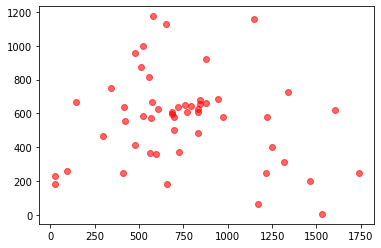

======epoch:0======time:0.486454,dist:8427.994557
======epoch:1======time:0.419793,dist:8427.994557
======epoch:2======time:0.415707,dist:7932.840059
======epoch:3======time:0.409575,dist:7932.840059
======epoch:4======time:0.422520,dist:7932.840059
The shortest distance is 7932 and the best path is: 

 city_0 -> city_21 -> city_45 -> city_15 -> city_49 -> city_19 -> city_22 -> city_30 -> city_17 -> city_2 -> city_16 -> city_20 -> city_41 -> city_6 -> city_1 -> city_29 -> city_28 -> city_43 -> city_33 -> city_34 -> city_35 -> city_38 -> city_39 -> city_37 -> city_36 -> city_47 -> city_23 -> city_4 -> city_14 -> city_5 -> city_3 -> city_24 -> city_11 -> city_27 -> city_26 -> city_25 -> city_46 -> city_12 -> city_13 -> city_51 -> city_10 -> city_50 -> city_32 -> city_42 -> city_9 -> city_8 -> city_7 -> city_40 -> city_18 -> city_44 -> city_31 -> city_48 ->city_0



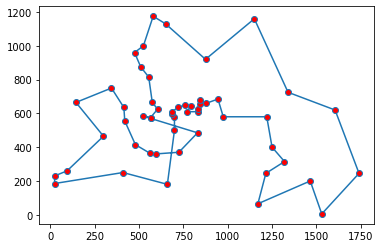

In [4]:
eachfile = 'tsp225.tsp'
epoch = 5
tsp_file = open('/mnt/TSPLIB/' + eachfile, mode='r', )
tsp_records = dict([])
temp = list([])
line = tsp_file.readline()
while line != 'EOF\n':  # 每一行最后跟个LF(\n)
    while line[0] == " ":
        line = line[1:]
    if line[0].isdecimal():
        temp_list = line.split(' ')
        while '' in temp_list:
            temp_list.remove('')
        tsp_records[int(temp_list[0])] = list([float(temp_list[1]), float(temp_list[2])])
    line = tsp_file.readline()


V, E = city_dis(tsp_records)
plt.scatter(V[:, 0], V[:, 1], alpha=0.6, c="r")  # 绘制散点图，透明度为0.6（这样颜色浅一点，比较好看）
plt.show()

ALG_name, best_dist, root = ACO(V, E, 80, epoch)
path = V[root]
path = np.append(path, [path[0]], axis=0)
plt.plot(path[:, 0], path[:, 1], marker="o", mfc="r")
plt.show()

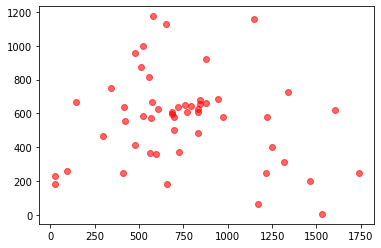

======epoch:0======time:0.000002,dist:99999999.000000
======epoch:1======time:0.420258,dist:8312.873044
======epoch:2======time:0.339138,dist:8312.873044
======epoch:3======time:0.286773,dist:8312.873044
======epoch:4======time:0.278408,dist:8312.873044
======epoch:5======time:0.264223,dist:8312.873044
The shortest distance is 8312.873043755135m and the best path is:  city_0 -> city_21 -> city_48 -> city_31 -> city_17 -> city_30 -> city_20 -> city_22 -> city_19 -> city_49 -> city_15 -> city_45 -> city_24 -> city_11 -> city_27 -> city_26 -> city_25 -> city_46 -> city_12 -> city_13 -> city_51 -> city_10 -> city_50 -> city_32 -> city_42 -> city_9 -> city_8 -> city_7 -> city_40 -> city_18 -> city_44 -> city_2 -> city_16 -> city_41 -> city_6 -> city_1 -> city_29 -> city_28 -> city_3 -> city_5 -> city_4 -> city_14 -> city_47 -> city_23 -> city_37 -> city_39 -> city_36 -> city_38 -> city_34 -> city_35 -> city_33 -> city_43 ->city_0.

!!!!1.1022106926220014!!!!


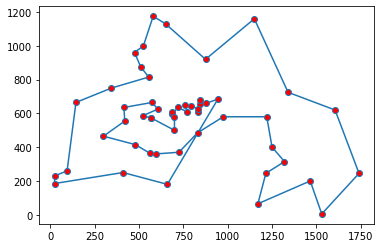

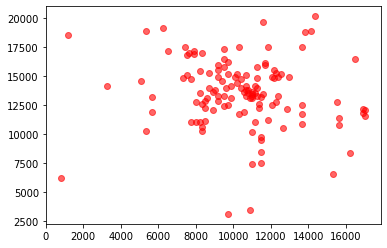

======epoch:0======time:0.000002,dist:99999999.000000
======epoch:1======time:1.502596,dist:142011.411636


KeyboardInterrupt: 

In [3]:
file_name_list = ['berlin52.tsp', 'bier127.tsp', 'ch130.tsp', 'ch150.tsp', 'd198.tsp', 'eil101.tsp',
                  'kroA100.tsp', 'kroA150.tsp', 'kroA200.tsp', 'kroB100.tsp', 'kroB150.tsp', 'kroB200.tsp',
                  'kroC100.tsp', 'kroD100.tsp', 'kroE100.tsp', 'lin105.tsp', 'pr76.tsp', 'pr124.tsp', 'pr136.tsp',
                  'pr144.tsp', 'pr152.tsp', 'rat99.tsp', 'rat195.tsp', 'rd100.tsp', 'st70.tsp', 'ts225.tsp',
                  'tsp225.tsp', 'u159.tsp']
file_top_dist = {'berlin52.tsp': 7542, 'bier127.tsp': 118282, 'ch130.tsp': 6110, 'ch150.tsp': 6528, 'd198.tsp': 15780,
                 'eil101.tsp': 629, 'kroA100.tsp': 21282, 'kroA150.tsp': 26524, 'kroA200.tsp': 29368,
                 'kroB100.tsp': 22141, 'kroB150.tsp': 26130, 'kroB200.tsp': 29437, 'kroC100.tsp': 20749,
                 'kroD100.tsp': 21294, 'kroE100.tsp': 22068, 'lin105.tsp': 14379, 'pr76.tsp': 108159,
                 'pr124.tsp': 59030, 'pr136.tsp': 96772, 'pr144.tsp': 56537, 'pr152.tsp': 73682, 'rat99.tsp': 1211,
                 'rat195.tsp': 2323, 'rd100.tsp': 7910, 'st70.tsp': 675, 'ts225.tsp': 126643, 'tsp225.tsp': 3916,
                 'u159.tsp': 42080}

epoch = 6
result = list([])
result_gap = list([])
folder_name = str(random.randint(1000,9999))
os.makedirs('/mnt/TSPLIB/png/folder_gen/{}'.format(folder_name))
ants_num = 50
for eachfile in file_name_list:
    tsp_file = open('/mnt/TSPLIB/' + eachfile, mode='r', )
    tsp_records = dict([])
    temp = list([])
    line = tsp_file.readline()
    while line != 'EOF\n':  # 每一行最后跟个LF(\n)
        while line[0] == " ":
            line = line[1:]
        if line[0].isdecimal():
            temp_list = line.split(' ')
            while '' in temp_list:
                temp_list.remove('')
            tsp_records[int(temp_list[0])] = list([float(temp_list[1]), float(temp_list[2])])
        line = tsp_file.readline()

    V, E = city_dis(tsp_records)
    plt.scatter(V[:, 0], V[:, 1], alpha=0.6, c="r")  # 绘制散点图，透明度为0.6（这样颜色浅一点，比较好看）
    plt.savefig('/mnt/TSPLIB/png/folder_gen/{0}/{1}_map.png'.format(folder_name, eachfile))
    plt.show()

    # ALG_name, best_dist, root = ACO(V, E, int(tsp_records.__len__() * 1.5), epoch)
    ALG_name, best_dist, root = MMAS(V, E, ants_num, epoch)
    result.append(float(best_dist/file_top_dist[eachfile]))
    path = V[root]
    path = np.append(path, [path[0]], axis=0)
    plt.plot(path[:, 0], path[:, 1], marker="o", mfc="r")
    plt.savefig('/mnt/TSPLIB/png/folder_gen/{0}/{1}_{2}_{3}_{4}.png'.format(folder_name, eachfile, ALG_name, epoch, best_dist))
    result_gap.append(np.array(result).mean())
    print("!!!!{}!!!!".format(result_gap[-1]))
    plt.show()
plt.plot(result_gap, "ob" ,alpha = 0.8, color = 'r')
plt.title('Mean Opt. Gap {}'.format(result_gap[-1]))
plt.grid()
plt.savefig('/mnt/TSPLIB/png/folder_gen/{0}/gap_{1}_{2}_{3}.png'.format(folder_name, ALG_name, epoch, result_gap[-1]))
plt.show()
shutil.move('/mnt/TSPLIB/png/folder_gen/{}'.format(folder_name),'/mnt/TSPLIB/png/folder_gen/{0}_ants{1}_lo0.2_beta8_{2}'.format(ALG_name, ants_num, result_gap[-1]))

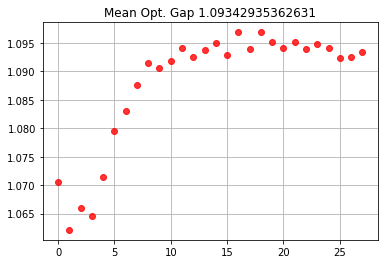

In [17]:
import os
plt.plot(result_gap, "ob" ,alpha = 0.8, color = 'r')
plt.title('Mean Opt. Gap {}'.format(result_gap[-1]))
plt.grid()
folder_name = 'TEST_0'
os.makedirs('/mnt/TSPLIB/png/{}'.format(folder_name))
plt.savefig('/mnt/TSPLIB/png/{0}/gap_{1}_{2}_{3}.png'.format(folder_name ,ALG_name, epoch, result_gap[-1]))
plt.show()

In [29]:

shutil.move('/mnt/TSPLIB/png/folder_gen/MMAS_0_1.23','/mnt/TSPLIB/png/folder_gen/test')



'/mnt/TSPLIB/png/folder_gen/test'